### Testing Evo

#### Imports

In [1]:
import torch
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from settings import *
from generator import generate_organism
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType, ModelType
from food_env import *
from online_tracker import OnlineTracker

#### Train the network

In [2]:
wall_amount = 20
food_amount = 1000
centered_env = Centered_Env(food_amount=food_amount, wall_amount=wall_amount)
cluster_env = Cluster_Env(clusters=60, cluster_size=30, wall_amount=wall_amount)
circle_env = Circle_Env(circles=4, food_amount=food_amount, wall_amount=wall_amount)
spiral_env = Spiral_Env(spirals=3, food_amount=food_amount, wall_amount=wall_amount)

In [3]:
train_config = Train_Config(stdev=0.05, popsize=20, 
    name='hidden14', problem_searcher=ProblemSearcher.CMAES,
    with_samplepool=False, timesteps=200)

In [4]:
generations = 200

settings = Settings(
    device = torch.device('cpu'),
    batch_size = 4,
    n = 20,
    #food_env=cluster_env,
    #food_env=centered_env,
    #food_env=circle_env,
    #food_env=spiral_env,
    food_envs=[centered_env, cluster_env, circle_env, spiral_env],
    scale = 4,
    wrap_around = True,
    
    model_type = ModelType.LocalOnly,
    #model_type = ModelType.WithGlobalNode,
    #model_type = ModelType.SmallWorld,

    radius = 0.04,
    radius_food_scale = 5,
    consume_radius_scale = 3/4, 
    consumption_edge_required = 1,
    #noise = 0.002,
    noise = 0.0,
    energy_required_to_replicate = 30,
    train_config=train_config,

    radius_wall_scale = 5,
    radius_wall_damage_scale = 1,
    wall_damage = 2,

    #only used if withGlobalNode
    #n2 = 
    radius_long_scale=2,
)

In [5]:
#TODO ADD settings like std of clusters..

online_tracker = OnlineTracker(settings)
trainer = Evo_Trainer(settings, online_tracker)
network = Conv(settings=settings)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mmho (gnca). Use `wandb login --relogin` to force relogin


In [ ]:
#trainer.train(10, 'temp')
#trainer.load_searcher() #load existing session

In [ ]:
generations=10000

In [ ]:
#TODO optionally add code for reconnecting to existing training session in case of lost connection

In [ ]:
trainer.train(generations)

         iter : 230
     stepsize : ReadOnlyTensor(0.0375)
pop_best_eval : 99.91954803466797
  median_eval : 89.71463012695312
    mean_eval : 87.79743957519531



In [ ]:
network = trainer.get_trained_network()
online_tracker.add_model(network)

#### Visualize trained network

In [ ]:
graphs = [generate_organism(settings).toGraph() for _ in range(settings.batch_size)]
loader = DataLoader(graphs, batch_size=settings.batch_size)
graph = next(iter(loader))
visualizer = Visualizer(settings)
network(graph, 0)

DataBatch(x=[4960, 11], edge_index=[1, 0], device=[4], subsize=[4], velocity=[4], border_cost=[4], food_reward=[4], dead_cost=[4], visible_food=[4], food_avg_dist=[4], food_avg_degree=[4], food_search_movement=[4], batch=[4960], ptr=[5])

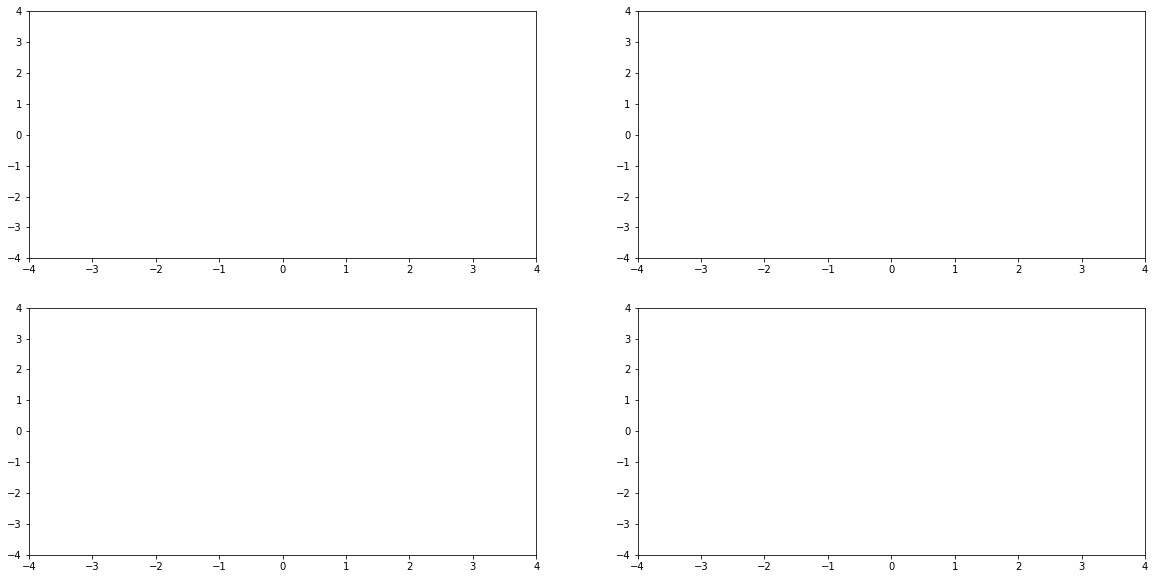

In [ ]:
#frames = 80 #test
frames = 100 #visualize

dpi = 100 #beautiful
#dpi = 50 #fast

anim = visualizer.animate_organism(graph, network, food=30, frames=frames) 
visualizer.save_animation_to_gif(anim, train_config.name, fps=10, dpi=dpi)

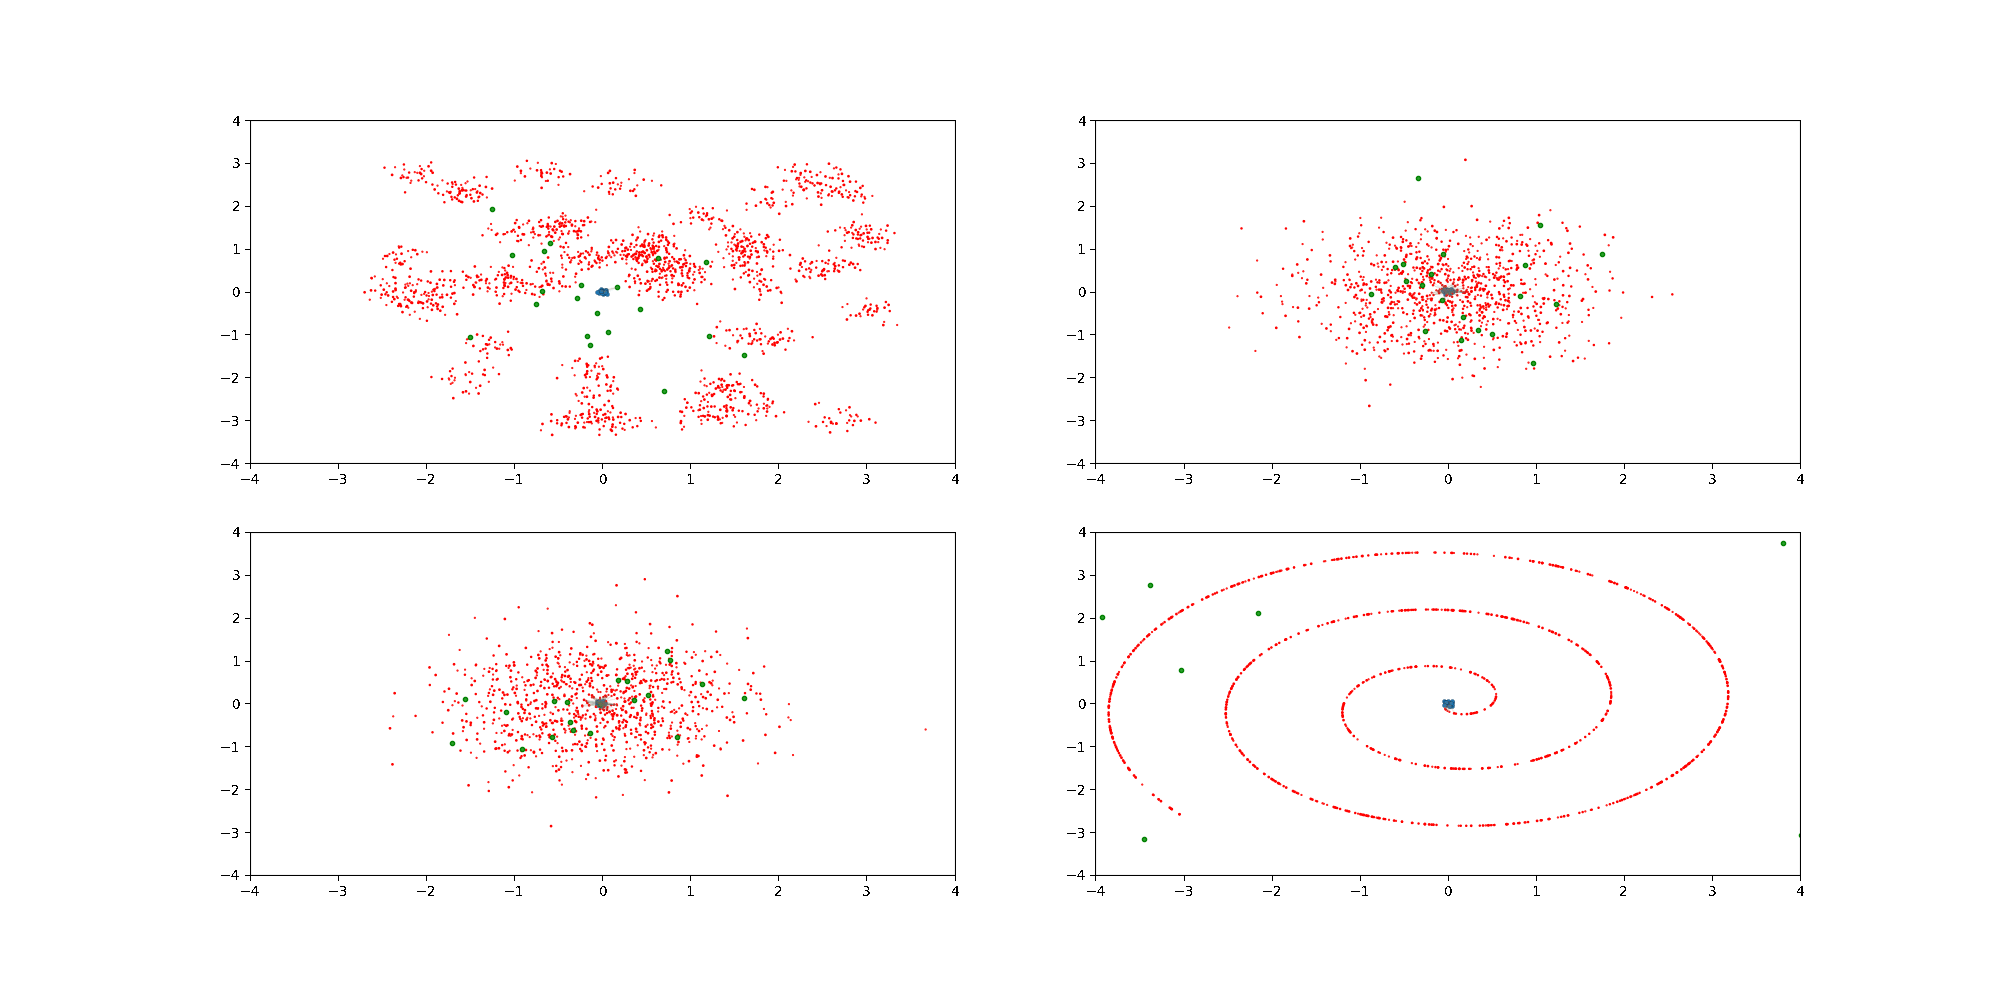

In [ ]:
Image('../animation/' + train_config.name + '.gif')

In [ ]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

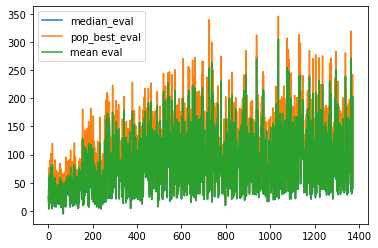

In [ ]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#print(losses)
#plt.plot(losses.stepsize)

if settings.train_config.problem_searcher == ProblemSearcher.GeneticAlgorithm:
    plt.plot(losses.obj0_median_eval)
    plt.plot(losses.obj0_pop_best_eval)
    plt.plot(losses.obj0_mean_eval)
else:
    plt.plot(losses.median_eval)
    plt.plot(losses.pop_best_eval)
    plt.plot(losses.mean_eval)
plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()

In [ ]:
online_tracker.finish()